# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2023**

**Мягкий дедлайн: 03.06.2023 23:59 MSK**

**Жёсткий дедлайн: 08.06.2023 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


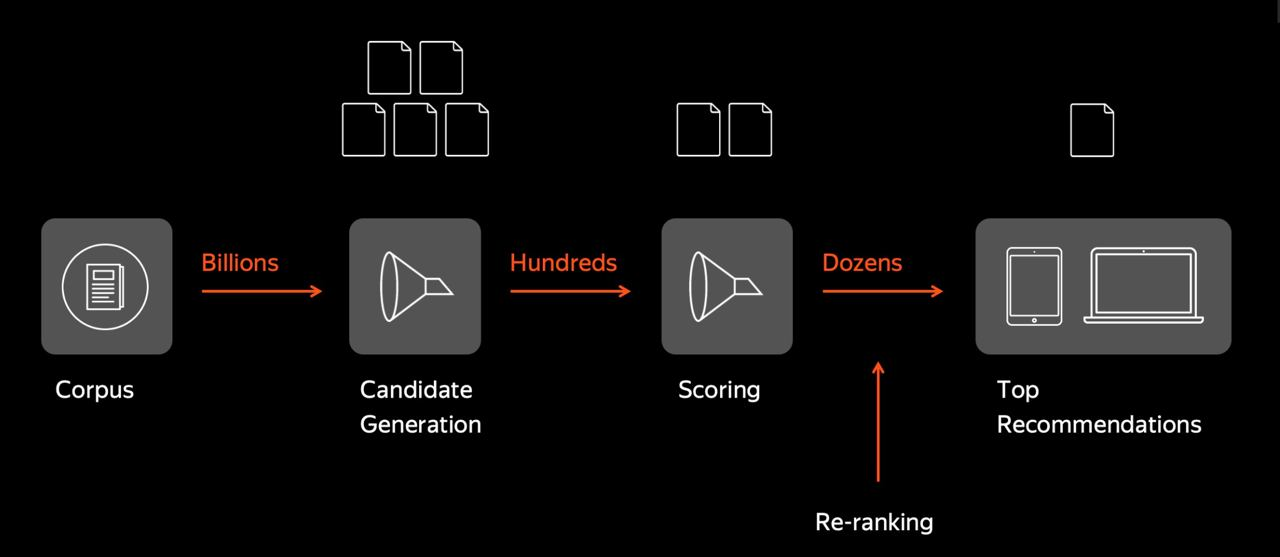

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    aps = []
    for index_user, user in enumerate(predicted):
        p_i = 0

        for i_k in range(k):
            if user[i_k] in relevant[index_user]:
                p_i += np.isin(user[:i_k+1], relevant[index_user]).sum()/(i_k+1)
        aps.append(p_i/min(k, len(relevant[index_user])))

    MAP = sum(aps)/len(predicted)
    return MAP

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
test_ratings

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168
...,...,...
6128,240,65864
6129,240,65953
6130,240,66287
6131,240,66348


In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for uid in range(self.n_users):
            test_preds += [self.recommend(uid)]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [17]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
def s(user_vector, v):
    return len(np.where((v > 0) & (user_vector > 0))[0])/len(np.where((v > 0) | (user_vector > 0))[0])

In [18]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return np.apply_along_axis(s, 1, ratings, user_vector)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [153]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        simil = self.similarity(self.R[uid])
        n = np.where(simil > self.alpha)[0][np.where(simil > self.alpha)[0] != uid]
        res = simil[n] @ self.R[n]
        return np.argsort(-res)

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [154]:
import time 

In [155]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
start = time.time()
user2user = User2User(train_ratings)
rec_jaccard = user2user.get_test_recommendations(50)
end = time.time() - start
print(end)

8.727407932281494


In [156]:
most_popular = ratings['trackId'].value_counts().index[:50]
rec_most = np.ones((len(test_users), 50)) * np.array(most_popular)

In [157]:
rec_random = np.array(list(np.random.choice(ratings['trackId'].unique(), 50) for _ in test_users))


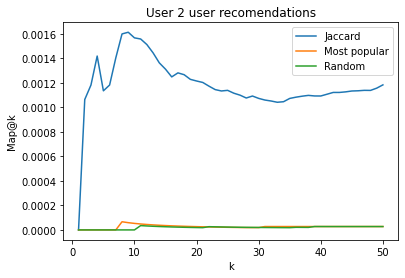

In [158]:
range_k = range(1, 50 + 1)
plt.plot(range_k, list(mapk(test_relevant, rec_jaccard, k) for k in range_k), label='Jaccard')
plt.plot(range_k, list(mapk(test_relevant, rec_most, k) for k in range_k), label='Most popular')
plt.plot(range_k, list(mapk(test_relevant, rec_random, k) for k in range_k), label='Random')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.title('User 2 user recomendations')
plt.show()

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [159]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from scipy.sparse import csr_matrix, find

def jaccard_vector(v, user_vector):
    return len(np.intersect1d(find(v)[1], find(user_vector)[1]))/len(find(v + user_vector > 0)[0])

def jaccard_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    return np.apply_along_axis(jaccard_vector, 1, ratings, user_vector)


def jaccard_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    return np.array(list(
        len(np.intersect1d(find(r)[1], find(user_vector)[1])) /
        len(find(r + user_vector > 0)[0])
            for r in ratings))

class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        simil = self.similarity(self.R[uid])
        n = np.where(simil > self.alpha)[0][np.where(simil > self.alpha)[0] != uid]
        res = simil[n] @ self.R[n]
        return np.argsort(-res)

class User2UserSparse(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)
        self.R = csr_matrix(self.R)

In [162]:
start = time.time()
user2user_jaccard_sparse = User2UserSparse(train_ratings, jaccard_sparse)
rec_sparse_jaccard = user2user_jaccard_sparse.get_test_recommendations(50)
end = time.time() - start
print(end)

26.214639902114868


Таким образом, время выполнения увеличилось. 

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [163]:
user_id = np.random.randint(0, user2user.n_users)

In [164]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
1238,This Is The Life,['Amy Macdonald']
1315,Du hast den schönsten Arsch der Welt,"['Alex C.', 'YASS']"
1422,Tienes El Culo Mas Bello Del Mundo,"['Alex C.', 'YASS']"
2039,Ненавижу,"[""Глюк'oZa""]"
2071,Снег идёт,"[""Глюк'oZa""]"
2202,Joe le taxi,['Vanessa Paradis']
2928,Temptation,"['Arash', 'Rebecca']"
2930,Arash,['Arash']
3418,Dub I Dub,['Me & My']
3643,Let The Love Go On,['Me & My']


In [165]:
preds = user2user.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
24500,Way Down We Go,['KALEO']
29105,Human,"[""Rag'n'Bone Man""]"
54280,Комета,['JONY']
6231,Yeah!,"['Usher', 'Lil Jon', 'Ludacris']"
8263,Shape Of My Heart,['Sting']
377,Buttons,['The Pussycat Dolls']
53422,Dance Monkey,['Tones And I']
11140,All That She Wants,['Ace of Base']
33436,Believer,['Imagine Dragons']
37782,Leave a Light On,['Tom Walker']


In [166]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_i \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Ответ

$$L = \sum_{(u, i) \in R} (\langle p_u, q_i \rangle - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)$$

$$ \nabla_{p_u} L = 2\sum\limits_i q_i (\langle p_u, q_i \rangle - r_{ui}) + \lambda 2p_u = 2\sum\limits_i (q_i q_i^{T} p_u - r_{ui}q_i) + 2\lambda p_u $$

$$ \nabla_{q_i} L = 2\sum\limits_u p_u (\langle p_u, q_i \rangle - r_{ui}) + \lambda 2q_i = 2\sum\limits_u (p_u p_u^{T} q_i - r_{ui}p_u) + 2\lambda q_i $$

$$ p_{u new} = p_u + learning rate * \nabla_{p_u} L  = p_u + 2learning rate * (q_i q_i^{T} p_u - r_{ui}q_i + \lambda p_u)$$

$$ q_{i new} = q_i + learning rate * \nabla_{q_i} L  = q_i + 2learning rate * (p_u p_u^{T} q_i - r_{ui}p_u + \lambda q_i)$$

**ALS:**

Ответ

$$ \nabla_{p_u} L = 2\sum\limits_i (q_i q_i^{T} p_u - r_{ui}q_i) + 2\lambda p_u  = 0$$

$$\sum\limits_i (q_i q_i^{T} p_u - r_{ui}q_i) + \lambda p_u  = 0$$

$$\sum\limits_i (q_i q_i^{T}  + \lambda) p_u  = \sum\limits_i r_{ui}q_i$$

$$p_u = (\sum\limits_i q_i q_i^{T}  + \lambda)^{-1} \sum\limits_i r_{ui}q_i \forall u$$

$$P = (QQ^T + \lambda)^{-1}QR^T$$



$$ \nabla_{q_i} L = 2\sum\limits_u (p_u p_u^{T} q_i - r_{ui}p_u) + 2\lambda q_i = 0$$

$$\sum\limits_u (p_u p_u^{T} q_i - r_{ui}p_u) + \lambda q_i  = 0$$

$$\sum\limits_u (p_u p_u^{T}  + \lambda) q_i   = \sum\limits_u r_{ui}p_u$$

$$q_i  = (\sum\limits_u p_u p_u^{T}  + \lambda)^{-1} \sum\limits_u r_{ui}p_u \forall i$$

$$Q = (PP^T + \lambda)^{-1}PR$$


**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [167]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(dim, self.n_users))
        self.Q = np.random.normal(size=(dim, self.n_items))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                u = np.random.randint(0, self.n_users)
                i = np.random.randint(0, self.n_items)
                p = self.P[:, u]
                q = self.Q[:, i]
                self.P[:, u] = p - 2 * self.lr * (p @ q * q - self.R[u][i] * q + self.lamb * p)
                self.Q[:, i] = q - 2 * self.lr * (p @ q * p - self.R[u][i] * p + self.lamb * q)
                
            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                self.P = np.linalg.inv(self.Q @ self.Q.T + self.lamb * np.eye(self.dim)) @ self.Q @ self.R.T
                self.Q = np.linalg.inv(self.P @ self.P.T + self.lamb * np.eye(self.dim)) @ self.P @ self.R

    def recommend(self, uid):
        pred_rating = self.Q.T @ self.P[:, uid]

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

In [169]:
for dim in [12, 32, 64, 128, 1000, 1024, 2048, 4096]:
    for iteration in [100, 500, 1000, 1500]:
        for k_glob in [10, 20, 30, 40, 50, 60]:
            model = LatentFactorModel(train_ratings, dim=dim, mode = 'sgd')

            model.fit(iteration)
            recs = model.get_test_recommendations(k_glob)
            best_mapk = 0
            for k in range(1, k_glob + 1):
                mapk_i = mapk(test_relevant, recs, k)
                if mapk_i > best_mapk:
                    best_mapk = mapk_i
                    best_dim = dim
                    best_iter = iteration
            best_k = k_glob
print(f'best params: dim = {best_dim}, num_iters = {best_iter}, k = {best_k}')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:01<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

best params: dim = 4096, num_iters = 1500, k = 60


In [171]:
for dim in [128, 564]:
    for iteration in [500, 1000]:
        model = LatentFactorModel(train_ratings, dim=dim, mode = 'als')

        model.fit(iteration)
        recs = model.get_test_recommendations(50)
        best_mapk = 0
        
        mapk_i = mapk(test_relevant, recs, 50)
        if mapk_i > best_mapk:
            best_mapk = mapk_i
            best_dim = dim
            best_iter = iteration

print(f'best params: dim = {best_dim}, num_iters = {best_iter}')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

best params: dim = 564, num_iters = 1000


In [172]:
model_sgd = LatentFactorModel(train_ratings, dim=4096, mode = 'sgd')
model_sgd.fit(1500)
model_als = LatentFactorModel(train_ratings, dim=564, mode = 'als')
model_als.fit(500)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [173]:
rec_sgd = model_sgd.get_test_recommendations(100)
rec_als = model_als.get_test_recommendations(50)

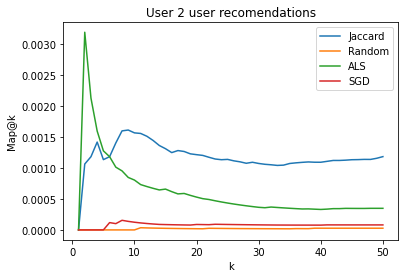

In [175]:
range_k = range(1, 50 + 1)
plt.plot(range_k, list(mapk(test_relevant, rec_jaccard, k) for k in range_k), label='Jaccard')
plt.plot(range_k, list(mapk(test_relevant, rec_random, k) for k in range_k), label='Random')
plt.plot(range_k, list(mapk(test_relevant, rec_als, k) for k in range_k), label='ALS')
plt.plot(range_k, list(mapk(test_relevant, rec_sgd, k) for k in range_k), label='SGD')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.title('User 2 user recomendations')
plt.show()

Таким образом, после отдельного подбора гиперпараметров для каждой модели лучшим алгоритмом на небольшом k является ALS, он выдает наибольшее МАР и лучше всего подстраивается под данные. Также большее количество итераций позволяет выдавать более подходящие рекомендации. 

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [176]:
model = model_als

In [177]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q.T @ model.Q[:, example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=0) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [178]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[:, example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.575695
5515,Романс,['Сплин'],0.507263
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.484006
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.475192
2179,Восьмиклассница,['КИНО'],0.456118
26075,Лошадка,['Найк Борзов'],0.451407
19118,Не спеши,['ЧайФ'],0.440813
15271,Маршруты московские,['Ва-Банкъ'],0.440813
5153,Stormbringer,['Deep Purple'],0.439694


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪


### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [213]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
als_top_100 = model_als.get_test_recommendations(100)
jaccard_top_100 = user2user.get_test_recommendations(100)
track_top = np.hstack((als_top_100, jaccard_top_100))

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [262]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

In [217]:
df = pd.DataFrame({'userId':np.repeat(test_users, 200), 'trackId': track_top.flatten()})

In [218]:
from scipy.spatial.distance import cosine

In [219]:
def cos_dist(userid, trackid):
    return cosine(model.P.T[userid], model.Q.T[trackid])

In [220]:
df['cosDist'] = df.apply(lambda x: cos_dist(x['userId'], x['trackId']), axis=1)

In [221]:
user_jac = {}
for user in df['userId'].unique():
    user_jac[user] = jaccard(user2user.R, user2user.R[user]).mean()

In [222]:
df['Jaccard'] = df['userId'].map(user_jac)
df['users_share'] = df['trackId'].map(pd.DataFrame(train_ratings['trackId'].value_counts()).to_dict()['trackId'])/len(df['userId'].unique())
df['num_songs'] = df['userId'].map(pd.DataFrame(train_ratings['userId'].value_counts()).to_dict()['userId'])

In [243]:
top_50 = {}   
for i in range(len(test_users)):
    user = test_users[i]
    top_50[user] = test_relevant[i]

In [244]:
def top_50_indicator(top_50_dict, user, track):
    if track in top_50_dict[user]:
        return 1
    else:
        return 0

In [245]:
df['target'] = df.apply(lambda x: top_50_indicator(top_50, x['userId'], x['trackId']), axis=1)
df

,userId,trackId,cosDist,Jaccard,users_share,num_songs,target
0,0,16242,0.999982,0.007585,0.119149,206,0
1,0,2555,0.999986,0.007585,0.178723,206,0
2,0,2814,0.999990,0.007585,0.246809,206,0
3,0,2527,0.999984,0.007585,0.097872,206,0
4,0,6198,0.999987,0.007585,0.114894,206,0
...,...,...,...,...,...,...,...
46995,240,42947,1.000005,0.008189,0.017021,1668,0
46996,240,9675,1.000005,0.008189,0.093617,1668,0
46997,240,22735,1.000003,0.008189,0.017021,1668,0
46998,240,15872,1.000004,0.008189,0.106383,1668,0


In [247]:
from sklearn.model_selection import train_test_split

In [248]:
X = df[['userId', 'trackId', 'cosDist', 'Jaccard', 'users_share', 'num_songs']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, stratify=y)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [249]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train[['userId', 'trackId', 'cosDist', 'Jaccard', 'users_share', 'num_songs']], y_train, group_id=X_train.sort_values(by=['userId'])['userId'])
test_pool = catboost.Pool(X_test[['userId', 'trackId', 'cosDist', 'Jaccard', 'users_share', 'num_songs']], y_test, group_id=X_test.sort_values(by=['userId'])['userId'])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [261]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_seed=42, depth=6)
cat.fit(train_pool, verbose=False)
catboost_pred_test = cat.predict(test_pool)
probs_cat = cat.predict_proba(test_pool)[:, 1]

In [262]:
test_df = X_test.copy()
test_df['catboost_predict'] = catboost_pred_test
test_df['catboost_probs'] = probs_cat
test_df['target'] = y_test
test_df = test_df.sort_values(by=['userId'])
test_df

,userId,trackId,cosDist,Jaccard,users_share,num_songs,catboost_predict,catboost_probs,target
174,0,2757,1.000003,0.007585,0.042553,206,0,2.932271e-04,0
197,0,19489,1.000004,0.007585,0.042553,206,0,3.163127e-03,0
82,0,10036,0.999987,0.007585,0.038298,206,0,1.543422e-04,0
180,0,14901,1.000001,0.007585,0.012766,206,0,4.432808e-04,0
129,0,13029,1.000000,0.007585,0.085106,206,0,5.818072e-04,0
...,...,...,...,...,...,...,...,...,...
46824,240,17788,0.999987,0.008189,0.034043,1668,0,1.299348e-06,0
46984,240,20971,1.000006,0.008189,0.008511,1668,0,1.521609e-05,0
46805,240,15518,0.999987,0.008189,0.051064,1668,0,8.791348e-07,0
46918,240,20589,1.000003,0.008189,0.021277,1668,0,1.035000e-05,0


In [263]:
df_probs = X.merge(test_df[['userId', 'trackId', 'catboost_probs']], on = ['userId', 'trackId'])

In [266]:
for user in df_probs['userId'].unique():
    if user == 0:
        m = np.array(df_probs[df_probs['userId'] == user].sort_values(by=['catboost_probs'], ascending=False)[:20]['trackId'])
    else:
        b = np.array(df_probs[df_probs['userId'] == user].sort_values(by=['catboost_probs'], ascending=False)[:20]['trackId'])
        m = np.vstack((m, b))

In [268]:
mapk(test_relevant, m, 20)

0.007510576476784236

In [275]:
class BaseModel:
    def __init__(self, df: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for uid in range(self.n_users):
            test_preds += [self.recommend(uid)]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]



class LatentFactorModel2(BaseModel):
    def __init__(self, df, dim=128, mode='sgd'):
        super().__init__(df)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(dim, self.n_users))
        self.Q = np.random.normal(size=(dim, self.n_items))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                u = np.random.randint(0, self.n_users)
                i = np.random.randint(0, self.n_items)
                p = self.P[:, u]
                q = self.Q[:, i]
                self.P[:, u] = p - 2 * self.lr * (p @ q * q - self.R[u][i] * q + self.lamb * p)
                self.Q[:, i] = q - 2 * self.lr * (p @ q * p - self.R[u][i] * p + self.lamb * q)
                
            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                self.P = np.linalg.inv(self.Q @ self.Q.T + self.lamb * np.eye(self.dim)) @ self.Q @ self.R.T
                self.Q = np.linalg.inv(self.P @ self.P.T + self.lamb * np.eye(self.dim)) @ self.P @ self.R

    def recommend(self, uid):
        pred_rating = self.Q.T @ self.P[:, uid]

        return np.argsort(pred_rating)[::-1]

In [276]:
model_als2 = LatentFactorModel2(df[['userId', 'trackId']], dim=564, mode = 'als')
model_als2.fit(500)
rec_als2 = model_als2.get_test_recommendations(20)

  0%|          | 0/500 [00:00<?, ?it/s]

In [281]:
mapk(test_relevant, rec_als2, 20)

4.728132387706856e-05

In [279]:
class User2User(BaseModel):
    def __init__(self, df):
        super().__init__(df)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        simil = self.similarity(self.R[uid])
        n = np.where(simil > self.alpha)[0][np.where(simil > self.alpha)[0] != uid]
        res = simil[n] @ self.R[n]
        return np.argsort(-res)

In [282]:
user2user = User2User(df[['userId', 'trackId']])
rec_u2u = user2user.get_test_recommendations(20)
mapk(test_relevant, rec_u2u, 20)

0.0004929078014184398

Таким образом, с помощью Catboost получилось значительно улучшить результаты. 

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪